<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/Predict_Stock_Price_with_LSTM_and_TCN_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# api_token = {"username":"srhgccc","key":"41c36ccc1ee7bc07f70e459ccbf7df7c"}
# import json
# import zipfile
# import os
 
# if not os.path.exists("/root/.kaggle"):
#     os.makedirs("/root/.kaggle")
 
# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)
# !chmod 600 /root/.kaggle/kaggle.json
 
# if not os.path.exists("/kaggle"):
#     os.makedirs("/kaggle")
# os.chdir('/kaggle')

In [2]:
# !kaggle datasets download -d mattiuzc/stock-exchange-data

In [3]:
# !unzip stock-exchange-data.zip

# Data Loading

In [4]:
!pip install -q FinMind

     |████████████████████████████████| 48 kB 1.7 MB/s 
     |████████████████████████████████| 316 kB 9.3 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 135 kB 41.9 MB/s 
     |████████████████████████████████| 761 kB 69.7 MB/s 
     |████████████████████████████████| 232 kB 64.2 MB/s 
     |████████████████████████████████| 96 kB 6.5 MB/s 
     |████████████████████████████████| 133 kB 56.4 MB/s 
     |████████████████████████████████| 386 kB 15.7 MB/s 
     |████████████████████████████████| 1.6 MB 47.6 MB/s 
     |████████████████████████████████| 139 kB 60.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
google-colab 1.0.0 requires ipython~=7.9.0, but

In [5]:
from FinMind.data import DataLoader

stock_no = '2454'
dl = DataLoader()
df = dl.taiwan_stock_daily(stock_id=stock_no, start_date='1950-01-01')
df.head()

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover
0,2001-07-23,2454,113000,33561000,297.0,297.0,297.0,297.0,0.0,113
1,2001-07-24,2454,14468937,4544216892,314.0,317.0,308.0,316.0,19.0,8618
2,2001-07-25,2454,5706246,1885975591,316.0,338.0,316.0,338.0,22.0,2558
3,2001-07-26,2454,3902035,1393645691,350.0,361.0,347.0,361.0,23.0,1992
4,2001-07-27,2454,3680150,1355696890,370.0,376.0,358.0,360.0,-1.0,2360


#LSTM

In [6]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# dataset = pd.read_csv('indexData.csv')
# dataset.head()
# dataset = dataset.sort_values(['日期'])
# dataset = pd.read_csv("/Users/leolin/Desktop/有點色的東西/LSTM-Multivariate_pollution.csv", header=0, index_col=0)
# dataset.head()

In [8]:
# dataset['Index'].unique()

In [9]:
# df = dataset[dataset['Index'] == 'SSMI']

In [10]:
df = df['close']

In [11]:
df = df.dropna()

In [12]:
df

0       297.0
1       316.0
2       338.0
3       361.0
4       360.0
        ...  
5294    651.0
5295    656.0
5296    638.0
5297    629.0
5298    625.0
Name: close, Length: 5299, dtype: float64

In [13]:
n = 0.75
train = df[0:int(n*df.shape[0]+1)].values
test = df[int(n*df.shape[0]):-1].values

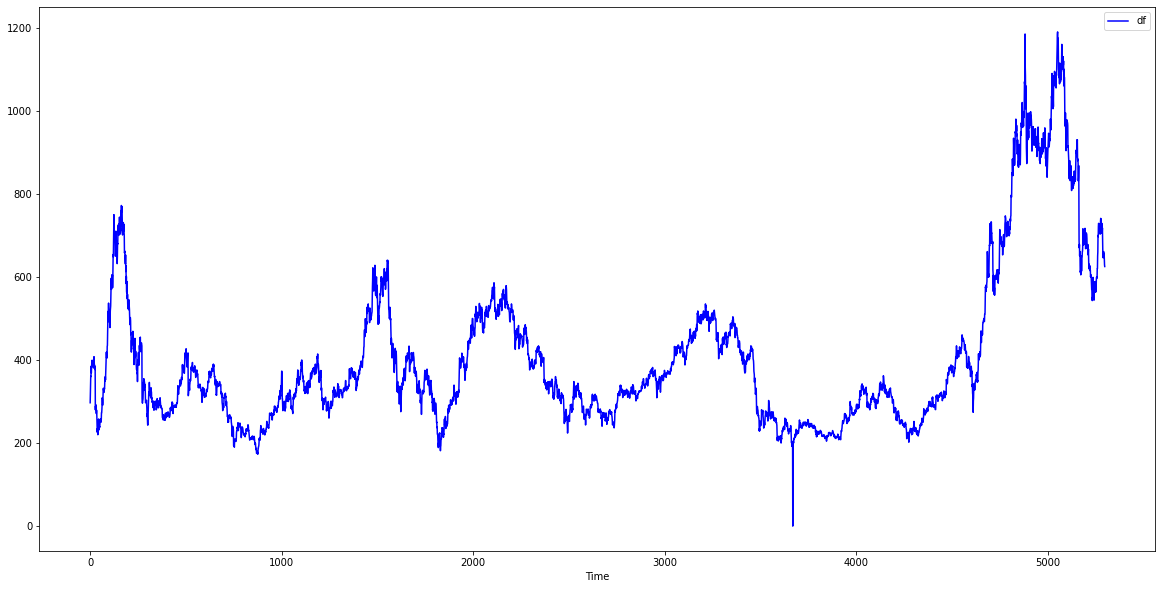

In [14]:
plt.figure(figsize=(20,10))
plt.plot(df.values, color = 'blue', label = 'df')  
plt.xlabel('Time')
plt.legend()
plt.show()

## Data Preprocessing

In [15]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train.reshape(-1, 1))

In [16]:
m = 30
x_train = []   #預測點的前 m 天的資料
y_train = []   #預測點
for i in range(m, len(train)):  
    x_train.append(train[i-m:i, 0])
    y_train.append(train[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)  

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=777, train_size=0.9)

In [19]:
batch_size = 256

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [20]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.MeanSquaredError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

In [21]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [22]:
# Initialising the RNN
model = Sequential()
keras.backend.clear_session()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation = 'relu'))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [23]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [24]:
import time

epochs = 50
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 1
Training loss (for one batch) at step 0: 0.2427
Seen so far: 256 samples
Training acc over epoch: 0.1301
Validation acc: 0.0187
Time taken: 22.87s

Start of epoch 2
Training loss (for one batch) at step 0: 0.0275
Seen so far: 256 samples
Training acc over epoch: 0.0164
Validation acc: 0.0062
Time taken: 4.90s

Start of epoch 3
Training loss (for one batch) at step 0: 0.0094
Seen so far: 256 samples
Training acc over epoch: 0.0108
Validation acc: 0.0072
Time taken: 3.31s

Start of epoch 4
Training loss (for one batch) at step 0: 0.0081
Seen so far: 256 samples
Training acc over epoch: 0.0083
Validation acc: 0.0047
Time taken: 3.34s

Start of epoch 5
Training loss (for one batch) at step 0: 0.0083
Seen so far: 256 samples
Training acc over epoch: 0.0071
Validation acc: 0.0029
Time taken: 3.34s

Start of epoch 6
Training loss (for one batch) at step 0: 0.0057
Seen so far: 256 samples
Training acc over epoch: 0.0062
Validation acc: 0.0023
Time taken: 3.35s

Start of epoch

In [25]:
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# model.fit(x_train, y_train, epochs = 50, batch_size = 256, callbacks=callback, validation_split = 0.2)

In [26]:
inputs = df.values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(len(train), len(inputs)):  # timesteps
    X_test.append(inputs[i-m:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [27]:
Y_pred = model.predict(X_test)
Y_pred = sc.inverse_transform(Y_pred)  # to get the original scale
Y_pred

42/42 [==============================] - 2s 17ms/step


array([[260.90292],
       [264.28214],
       [267.26624],
       ...,
       [567.23553],
       [560.98395],
       [556.017  ]], dtype=float32)

In [28]:
Y_pred.shape

(1324, 1)

In [29]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error:",mean_absolute_error(test,Y_pred))
print("mean_squared_error:",mean_squared_error(test,Y_pred))
print("rmse:",sqrt(mean_squared_error(test,Y_pred)))
print("r2 score:",r2_score(test,Y_pred))

mean_absolute_error: 69.53637425632995
mean_squared_error: 8743.646348670072
rmse: 93.50746680704206
r2 score: 0.8889807805866331


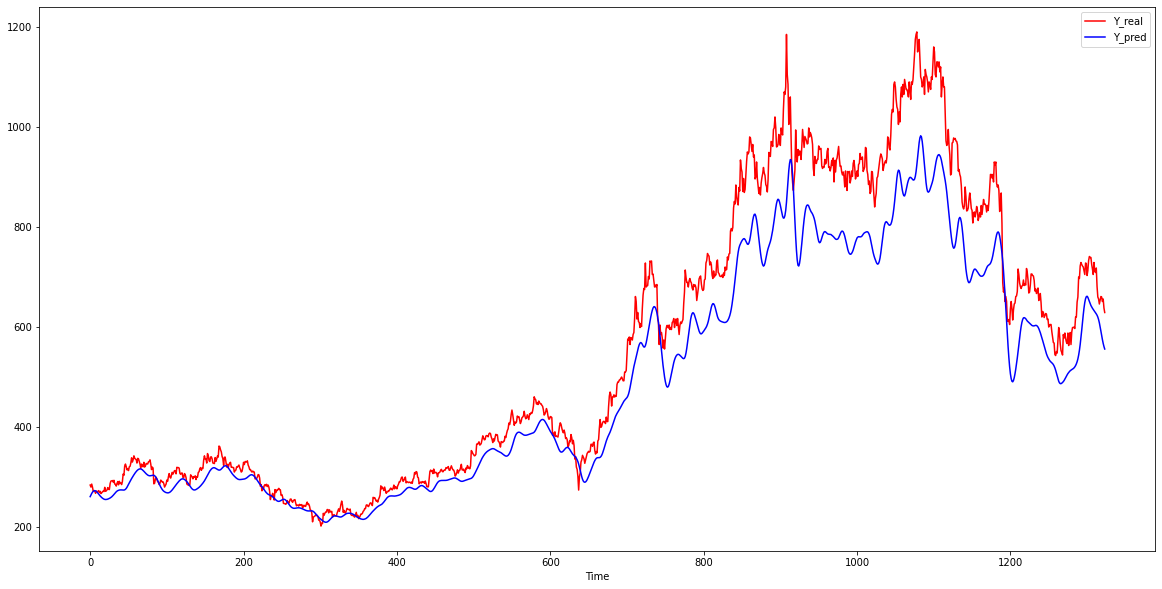

In [30]:
# Visualising the results
plt.figure(figsize=(20,10))
plt.plot(test, color = 'red', label = 'Y_real')  
plt.plot(Y_pred, color = 'blue', label = 'Y_pred')  
plt.xlabel('Time')
plt.legend()
plt.show()

#TCN

In [66]:
!pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

## hyperparameter

In [166]:
window_size = m
batch_size = 32   
epochs = 100       
filter_nums = 32
kernel_size = 2

In [167]:
scaler = MinMaxScaler()
open_arr = scaler.fit_transform(df.values.reshape(-1, 1)).reshape(-1)

In [168]:
X = np.zeros(shape=(len(open_arr) - window_size, window_size))
label = np.zeros(shape=(len(open_arr) - window_size))
for i in range(len(open_arr) - window_size):
    X[i, :] = open_arr[i:i+window_size]
    label[i] = open_arr[i+window_size]

In [169]:
k = int(X.shape[0]*n)
x_train = X[:k, :]
y_train = label[:k]
x_test = X[k:-1, :]
y_test = label[k:-1]

In [170]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [171]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=77777, train_size=0.9)

In [172]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((3555, 30, 1), (3555,), (396, 30, 1), (396,), (1317, 30, 1), (1317,))

In [173]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [174]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.MeanSquaredError()
val_acc_metric = tf.keras.metrics.MeanSquaredError()

In [175]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [182]:
from tcn.tcn import TCN

dilations = np.logspace(1, kernel_size, kernel_size, base=2, dtype=int).tolist()

model = keras.models.Sequential([
    keras.layers.Input(shape=(window_size, 1)),
    TCN(nb_filters=filter_nums,
        kernel_size=kernel_size,
        dilations=dilations),     
    keras.layers.Dense(units=1, activation='relu')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_12 (TCN)                (None, 32)                6400      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________


In [183]:
import time

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 1
Training loss (for one batch) at step 0: 0.1920
Seen so far: 32 samples
Training acc over epoch: 0.0077
Validation acc: 0.0002
Time taken: 5.75s

Start of epoch 2
Training loss (for one batch) at step 0: 0.0002
Seen so far: 32 samples
Training acc over epoch: 0.0001
Validation acc: 0.0001
Time taken: 0.92s

Start of epoch 3
Training loss (for one batch) at step 0: 0.0001
Seen so far: 32 samples
Training acc over epoch: 0.0001
Validation acc: 0.0002
Time taken: 1.32s

Start of epoch 4
Training loss (for one batch) at step 0: 0.0002
Seen so far: 32 samples
Training acc over epoch: 0.0001
Validation acc: 0.0001
Time taken: 0.93s

Start of epoch 5
Training loss (for one batch) at step 0: 0.0002
Seen so far: 32 samples
Training acc over epoch: 0.0001
Validation acc: 0.0001
Time taken: 0.94s

Start of epoch 6
Training loss (for one batch) at step 0: 0.0001
Seen so far: 32 samples
Training acc over epoch: 0.0001
Validation acc: 0.0001
Time taken: 0.93s

Start of epoch 7
Trai

In [184]:
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=callback)

In [185]:
model.evaluate(x_test, y_test)
prediction = model.predict(x_test)
scaled_prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)
scaled_test_label = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

42/42 [==============================] - 0s 5ms/step


In [186]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("mean_absolute_error:",mean_absolute_error(scaled_prediction, scaled_test_label))
print("mean_squared_error:",mean_squared_error(scaled_prediction, scaled_test_label))
print("rmse:",sqrt(mean_squared_error(scaled_prediction, scaled_test_label)))
print("r2 score:",r2_score(scaled_prediction, scaled_test_label))

mean_absolute_error: 10.969148779241262
mean_squared_error: 289.1777073247315
rmse: 17.005225882790604
r2 score: 0.9962730345718712


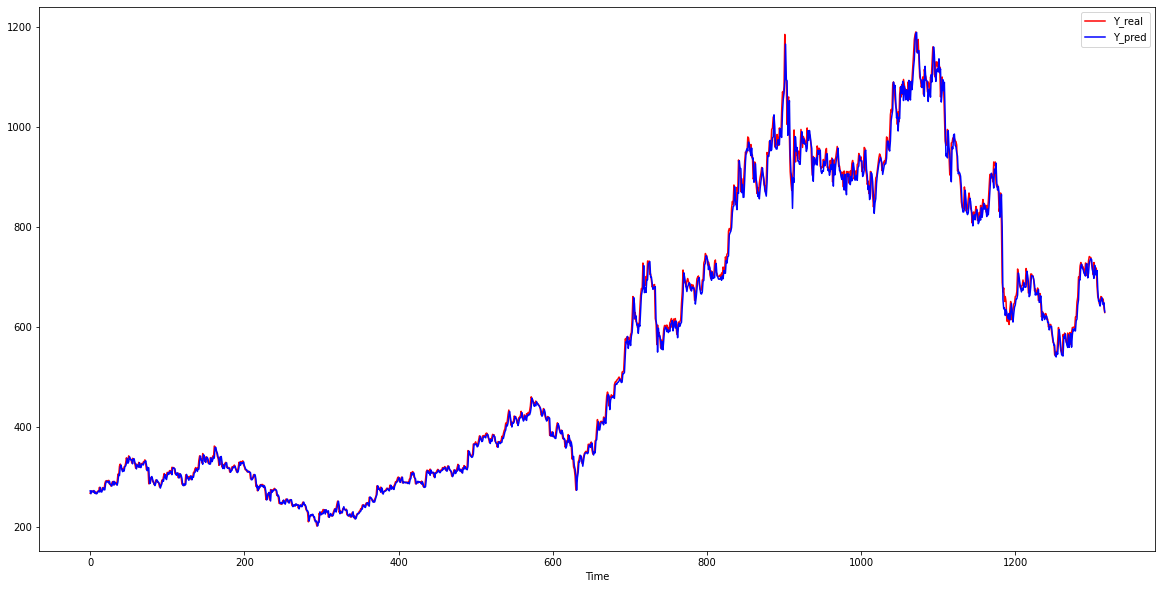

In [187]:
plt.figure(figsize=(20,10))
plt.plot(scaled_test_label, color = 'red', label = 'Y_real')  
plt.plot(scaled_prediction, color = 'blue', label = 'Y_pred')  
plt.xlabel('Time')
plt.legend()
plt.show()